In [1]:
%run setup.py
%load_ext autoreload 
%autoreload 2

from keplergl import KeplerGl
import geopandas as gpd

import cba as cba
from cba_result import CbaResult
from section import Section

from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display
from IPython.html import widgets
plt.style.use('seaborn')

display(HTML("<style>.container { width:95% !important; }</style>"))

c:\users\pedro\.virtualenvs\roads-cba-py-hwfftmxk\lib\site-packages\IPython\html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


HTML(value='<style>.container { width:95% !important; }</style>')

In [2]:
gdf = gpd.read_file(abspath(join('..', '..', '..', 'RoADS-CBA', 'sections_generated.gpkg')))
# gdf = gpd.read_file(abspath(join('..', 'data', 'sections_generated.gpkg')))

cba_model = cba.CostBenefitAnalysisModel()

Wall time: 19.3 s


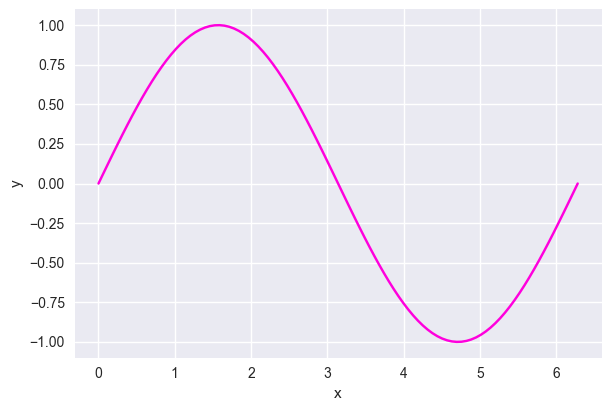

In [3]:
%matplotlib widget 
import ipywidgets
output = ipywidgets.Output()
 
# create some x data
x = np.linspace(0, 2 * np.pi, 100)
 
# default line color
initial_color = '#FF00DD'
 
with output:
    fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))
     
# move the toolbar to the bottom
fig.canvas.toolbar_position = 'bottom'
ax.grid(True)    
line, = ax.plot(x, np.sin(x), initial_color)

# create some control elements
int_slider = ipywidgets.IntSlider(value=1, min=0, max=10, step=1, description='freq')
color_picker = ipywidgets.ColorPicker(value=initial_color, description='pick a color')
text_xlabel = ipywidgets.Text(value='', description='xlabel', continuous_update=False)
text_ylabel = ipywidgets.Text(value='', description='ylabel', continuous_update=False)
 
# callback functions
def update(change):
    """redraw line (update plot)"""
    line.set_ydata(np.sin(change.new * x))
    fig.canvas.draw()
     
def line_color(change):
    """set line color"""
    line.set_color(change.new)
     
def update_xlabel(change):
    ax.set_xlabel(change.new)
     
def update_ylabel(change):
    ax.set_ylabel(change.new)
 
# connect callbacks and traits
int_slider.observe(update, 'value')
color_picker.observe(line_color, 'value')
text_xlabel.observe(update_xlabel, 'value')
text_ylabel.observe(update_ylabel, 'value')
 
text_xlabel.value = 'x'
text_ylabel.value = 'y'
controls = ipywidgets.VBox([int_slider, color_picker, text_xlabel, text_ylabel])
ipywidgets.HBox([controls, output])

CPU times: user 1.78 s, sys: 37.5 ms, total: 1.82 s
Wall time: 3.46 s


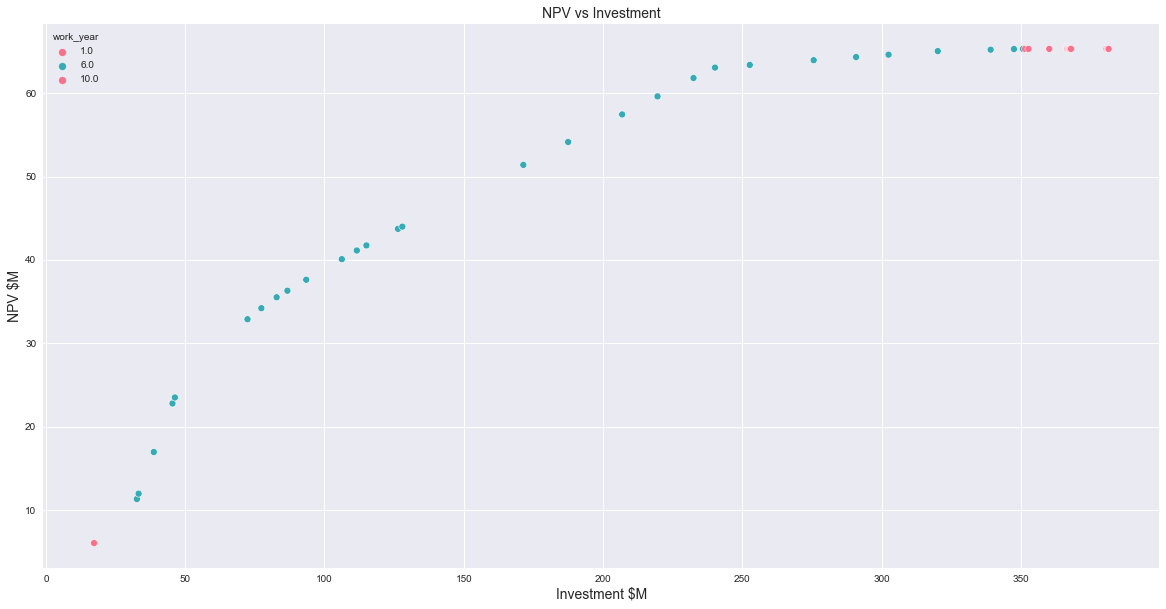

In [241]:
%%time
def generate_outputs(growth, limit):
    foo = gdf.assign(section_traffic_growth = growth).head(limit)
    input = foo.apply(lambda row: Section.from_row(row), axis=1)
    output = [cba_model.compute_cba_for_section(i) for i in input]

    output = pd.DataFrame([e.to_dict() for e in output])
    cols_to_drop = [e for e in list(output.columns) if re.match('.*_[0-9].*', e)]
    output = output.drop(columns=cols_to_drop)
    
    map_data = gdf.merge(output, left_on='way_id_district', right_on='orma_way_id')
    
    map_data.sort_values(by=['work_year', 'npv_cost'], ascending=[True, False], inplace=True)
    map_data['cum_investment'] = np.cumsum(map_data['work_cost'])
    map_data['cum_npv'] = np.cumsum(map_data.npv)

    return map_data


def plot_cum_npv(map_data):
    plt.figure(figsize=(20,10))
    sns.scatterplot(data=map_data, x='cum_investment', y='cum_npv', hue='work_year', palette='husl')
    plt.xlabel("Investment $M", fontsize=14)
    plt.ylabel("NPV $M", fontsize=14)
    plt.title(f'NPV vs Investment', fontsize=14)

full_data = generate_outputs(3, 50) # len(gdf))
plot_cum_npv(full_data)

In [4]:
def handle_growth(growth):
    df = generate_outputs(growth, 200)
    plot_cum_npv(df)
    plt.figure()
    invest_by_year = df.groupby('work_year')['work_cost'].sum().reset_index()
    sns.barplot(data=invest_by_year, x='work_year', y='work_cost',  palette='Set2')
    
interact(handle_growth, growth=(1,5,1))

interactive(children=(IntSlider(value=3, description='growth', max=5, min=1), Output()), _dom_classes=('widget…

<function __main__.handle_growth(growth)>

In [5]:
config_file = join('.', 'kepler_config.json')
with open(config_file, 'r') as file:
    config = eval(''.join(file.readlines()))

In [6]:
map_1 = KeplerGl(height=1000, config=config)
map_1.add_data(data=full_data, name="homogeneous_links")
map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['homogeneous_links'], 'id': …

In [8]:
config_file = join('.', 'kepler_config.work_year.json')
with open(config_file, 'w') as file:
    file.write(str(map_1.config))

In [239]:
map_data

,VPROMM_ID,way_id_district,road number,name,road start location,road end location,province,district,section_commune_gso,management,x_0,y_0,x_1,y_1,length,section_lanes,width,link_class,section_terrain,section_temperature,section_moisture,surface,section_surface,condition,iri,section_pavement_age,section_traffic,section_motorcycle,section_small_car,section_medium_car,section_four_wheel,section_delivery_vehicle,section_light_truck,section_medium_truck,section_heavy_truck,section_articulated_truck,section_small_bus,section_medium_bus,section_large_bus,aadt,section_traffic_growth,geometry,orma_way_id,work_class,work_type,work_name,work_cost,work_cost_km,work_year,npv,npv_km,npv_cost,eirr,truck_percent,vehicle_utilization,esa_loading,cum_investment,cum_npv
387,034QB00094,637220_299,ĐX.94,Đường từ trạm hạ thế đi thôn Cán Hồ,None,None,Hà Giang,Huyện Quản Bạ,None,None,105.140616,22.981539,105.132447,22.994503,2.646040,None,3.0,8,3,1,4,None,5,5,None,13,2,None,None,None,None,None,None,None,None,None,None,None,None,None,3,LINESTRING (105.1406161000000026 22.9815390999...,637220_299,Rehabilitation,E-R,Reconstruction (Earth),0.190515,0.072000,1.0,0.223272,0.084380,1.171938,-0.035159,0.15,0.072435,0.001374,0.190515,0.223272
847,034BM00003,638688_301,ĐX.03,Bản Sáp - Bản Đuốc,None,None,Hà Giang,Huyện Bắc Mê,None,None,105.359051,22.753084,105.365869,22.751458,0.989120,None,3.0,8,3,1,4,None,5,5,None,14,2,None,None,None,None,None,None,None,None,None,None,None,None,None,3,LINESTRING (105.3590508999999997 22.7530840000...,638688_301,Rehabilitation,E-R,Reconstruction (Earth),0.071217,0.072000,1.0,0.083462,0.084380,1.171938,-0.035159,0.15,0.027077,0.001374,0.261732,0.306733
526,034QG00030,637541_305,ĐX.30,UBND xã - Tây sơn,None,None,Hà Giang,Huyện Quang Bình,None,None,104.657242,22.319378,104.660670,22.323678,0.623709,None,3.0,8,3,1,4,None,5,5,None,14,2,None,None,None,None,None,None,None,None,None,None,None,None,None,3,LINESTRING (104.6572416000000061 22.3193783000...,637541_305,Rehabilitation,E-R,Reconstruction (Earth),0.044907,0.072000,1.0,0.052628,0.084380,1.171938,-0.035159,0.15,0.017074,0.001374,0.306639,0.359362
715,034XM00111,637951_303,ĐX.111,Tuyế Lủng Cháng,None,None,Hà Giang,Huyện Xín Mần,None,None,104.487632,22.606762,104.502470,22.606550,2.587349,None,3.0,8,3,1,4,None,5,5,None,11,2,None,None,None,None,None,None,None,None,None,None,None,None,None,3,LINESTRING (104.4876316000000003 22.6067615999...,637951_303,Rehabilitation,E-R,Reconstruction (Earth),0.186289,0.072000,1.0,0.218319,0.084380,1.171938,-0.035159,0.15,0.070829,0.001374,0.492928,0.577681
621,033XM00003,637853_303,ĐH.03,Xín Mần - Chí Cà -Pà Vầy Sủ,"Km16, ĐH.01",Chí Cà,Hà Giang,Huyện Xín Mần,None,3,104.382097,22.685834,104.489368,22.729192,28.625499,None,3.5,7,3,1,4,None,3,5,None,13,4,None,None,None,None,None,None,None,None,None,None,None,None,None,3,LINESTRING (104.3820967000000053 22.6858341000...,637853_303,Rehabilitation,B-R2,Reconstruction Type V,39.775131,1.389500,1.0,16.023720,0.559771,0.402858,0.238763,0.18,3.918115,0.013195,40.268059,16.601401
553,033QG00006,637578_305,ĐH.06,Tiên Yên - Hương Sơn - Yên Hà,"Km32, ĐT.183, xã Tiên Yên",UBND xã Yên Hà,Hà Giang,Huyện Quang Bình,None,3,104.649400,22.334248,104.576927,22.286680,15.439526,None,3.5,7,3,1,4,None,3,5,None,13,4,None,None,None,None,None,None,None,None,None,None,None,None,None,3,LINESTRING (104.6494000000000000 22.3342482999...,637578_305,Rehabilitation,B-R2,Reconstruction Type V,21.453222,1.389500,1.0,8.642597,0.559771,0.402858,0.238763,0.18,2.113285,0.013195,61.721281,25.243998
398,033YM00008,637262_298,ĐH.08,Mậu Duệ - Ngam La,"Km72, ĐT.176B",UBND xã Ngam La,Hà Giang,Huyện Yên Minh,None,3,105.183854,23.066146,105.220330,23.063108,5.724188,None,3.5,7,3,1,4,None,3,5,None,13,4,None,None,None,None,None,None,None,None,None,None,None,None,None,3,LINESTRING (105.1838541000000049 23.0661464000...,637262_298,Rehabilitation,B-R2,Reconstruction Type V,7.953759,1.389500,1.0,3.204233,0.559771,0.402858,0.238763,0.18,0.783498,0.0131